In [1]:
import sys, os
import netCDF4
import scipy.io, numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.patches as mpatches

In [2]:
# generate k-pdf plots
def kappaPDF(directory, date):
    xnew = np.linspace(0, 1.3, 30) # K0
    df_k = pd.DataFrame(columns=['dia', 'K0', 'dNdK'])

    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filename = subdir + os.sep + file
            if (f'houaoshtdmaM1.b1.{date}' in filename):
            
    # =============== FOR EACH FILE ===============
    # get dimensions of time and bins
                ds = netCDF4.Dataset(filename)
                s1 = str(ds.dimensions['time'])
                s2 = str(ds.dimensions['bin'])
                # print(s)
                x = -3
                if (s1[x-1:x+1] != '='):
                    dim_time = int(s1[x:])
                else:
                    dim_time = int(s1[x-1:])
                if (s2[x-1:x+1] != '='):
                    dim_bin = int(s2[x:])
                else:
                    dim_bin = int(s2[x-1:])

    # CHANGE HERE: define arrays
                time = np.zeros(dim_time)
                dry_dia = np.zeros(dim_time)
                kappa = np.zeros((dim_time, dim_bin))
                k_bound = np.zeros((dim_time, dim_bin,2))
                conc = np.zeros((dim_time, dim_bin))
                
    # CHANGE HERE: read data into arrays
                ncf = scipy.io.netcdf_file(filename, mmap=False)
                date = int(filename[-18:-10]) # read i.e. 20210427
                time[:] = ncf.variables["time"].data/3600 # hr
                dry_dia[:] = ncf.variables["dry_diameter_setting"].data # nm
                for i_time in range(dim_time):
                    kappa[i_time, :] = ncf.variables['kappa'][i_time, :]
                    k_bound[i_time, :, :] = ncf.variables['kappa_bounds'][i_time, :, :]
                    conc[i_time,:] = ncf.variables['aerosol_concentration'][i_time, :] # dN, unit: 1/cm^3

    # calculations
                dK = np.zeros((dim_time,dim_bin))
                for i_time in range(dim_time):
                    dK[i_time, :] = k_bound[i_time, :, 1] -  k_bound[i_time, :, 0]
                conc_norm0 = np.zeros((dim_time,dim_bin)) # dN/dK
                for i_time in range(dim_time):
                    conc_norm0[i_time, :] = conc[i_time, :]/dK[i_time, :]
                
    # use pandas to manipulate data
                d = {'dry_dia': dry_dia, 'time':time, 'date':date}
                df = pd.DataFrame(data = d)
                #print(df)
        
                df_conc = pd.DataFrame(conc)
                # print(df_conc)
                N_tot = df_conc.sum(axis=1)# N_tot (series) for each scan
                N_tot.name = "N_tot"
                #print(N_tot) 
                #print(type(N_tot)) # Series
                
                df = df.join(N_tot)
                # print(df)
                Ntot = N_tot.to_numpy()
                conc_norm = np.zeros((dim_time,dim_bin))
                for i_time in range(dim_time):
                    conc_norm[i_time, :] = conc_norm0[i_time, :]/Ntot[i_time]
                # print(conc_norm)

                dNdK = np.zeros((dim_time,30))
                for i_time in range(dim_time):
                # i_time = 1
                    # dia = dry_dia[i_time]
                    x = kappa[i_time,:] # one scan:kappa
                    y = conc_norm[i_time,:] # one scan: c(k)
                    f = interpolate.interp1d(x,y,fill_value="extrapolate", kind='nearest')
                    ynew = f(xnew)
                    dNdK[i_time,:] = ynew
                dia = np.repeat(dry_dia, 30) # for one scan
                x_flat = np.tile(xnew, dim_time) # for different bin
                # print(x_flat)
                y_flat = dNdK.ravel()
                # print(y_flat.shape)

                temp_df = pd.DataFrame({'dia': dia,'K0': x_flat,'dNdK': y_flat})
                df_k = pd.concat([df_k, temp_df], ignore_index=True)

                def k_size(df_k,size):
                    if size == 50:
                        df_k_i = df_k[df_k["dia"] == 50]  
                    elif size == 100:
                        df_k_i = df_k[df_k["dia"] == 100]
                    elif size == 150:
                        df_k_i = df_k[df_k["dia"] == 150]
                    elif size == 200:
                        df_k_i = df_k[df_k["dia"] == 200]  
                    elif size == 250:
                        df_k_i = df_k[df_k["dia"] == 250]  

                    dNdK_i = df_k_i['dNdK'].to_numpy()
                    d_scan = int(df_k_i.shape[0]/30)
                    dNdK_i_matrix = dNdK_i.reshape(d_scan, 30)
                    # print(np.isnan(dNdK100_matrix).any()) 
                    dNdK_i_matrix = np.nan_to_num(dNdK_i_matrix) # could result in inaccuracy -> should remove this data when calculating the average
                    # print(dNdK100_matrix.shape)
                    avg_i = np.mean(dNdK_i_matrix, axis=0)

                    return df_k_i.K0, df_k_i.dNdK, avg_i
                
                x50, y50, avg50 = k_size(df_k,50)
                x100, y100, avg100 = k_size(df_k,100)
                x150, y150, avg150 = k_size(df_k,150)
                x200, y200, avg200 = k_size(df_k,200)
                x250, y250, avg250 = k_size(df_k,250)

                date_str = f"{date:8}"  # Convert to string for formatting
                formatted_date = f"{date_str[0:4]}-{date_str[4:6]}-{date_str[6:8]}"

                plt.plot(xnew,avg50, label='50 cm', c='tab:red')
                plt.plot(xnew,avg100, label='100 cm', c='tab:green')
                plt.plot(xnew,avg150, label='150 cm', c='tab:blue')
                plt.plot(xnew,avg200, label='200 cm', c='tab:purple')
                plt.plot(xnew,avg250, label='250 cm', c='tab:orange')
                plt.ylim(0,10)
                plt.legend()
                plt.title(f'Κ-pdf for all diameters on {formatted_date}')
                plt.xlabel('Κ')
                plt.ylabel('pdf')
                plt.show()

/var/folders/n8/bjc7cpvs3hnd3g97l3ky6q4w0000gn/T/ipykernel_29032/3438300488.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_k = pd.concat([df_k, temp_df], ignore_index=True)


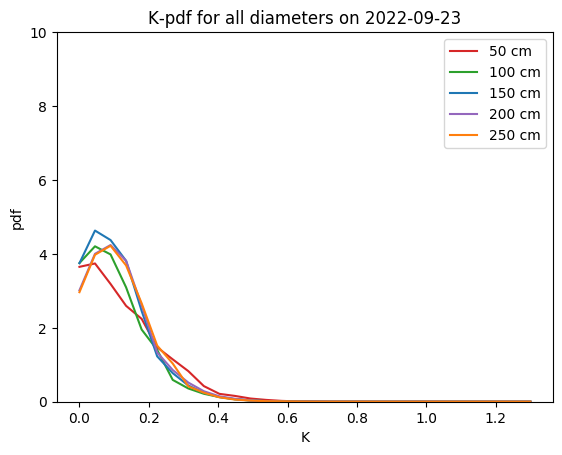

In [3]:
kappaPDF('/Users/evenhou/Downloads/HOU_data',20220923)